In [1]:
import jax.numpy as jnp
import bayes3d as b
import os
import jax
import functools
from jax.scipy.special import logsumexp
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
import bayes3d.genjax
import genjax
import pathlib


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7040/static/


In [3]:
def get_filter_scores(
    ij,
    observed_xyz: jnp.ndarray,
    rendered_xyz: jnp.ndarray,
    variance,
    outlier_prob,
    outlier_volume,
    focal_length,
    filter_size
):
    rendered_xyz_padded = jax.lax.pad(rendered_xyz,  -100.0, ((filter_size,filter_size,0,),(filter_size,filter_size,0,),(0,0,0,)))

    p = observed_xyz[ij[0], ij[1], :3]
    filter_latent = jax.lax.dynamic_slice(rendered_xyz_padded, (ij[0], ij[1], 0), (2*filter_size + 1, 2*filter_size + 1, 3))

    half_widths = (filter_latent[:,:,2] / focal_length) / 2.0

    probabilities = b.compute_score(filter_latent, p, focal_length, variance)
    probabilities_normalized = probabilities + jnp.log(((2*half_widths)**2)) - jnp.log(((2*half_widths)**2).sum())  + 2*jnp.log(width_observed)

    return probabilities_normalized

In [4]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)



[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [5]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.8, .15]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)

In [6]:
width = 0.015
ang = jnp.pi
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    17,17,101
)

In [7]:
enumerators = b.make_enumerator(["contact_params_1"])

In [8]:
key = jax.random.PRNGKey(100)

In [87]:
def make_orientation_posterior_viz(observation, gt_contact, sampled_contacts):
    fig = plt.figure(constrained_layout=True)
    # fig.suptitle(f"Variance: {variance} Outlier Prob: {outlier_prob}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2],max=1.4)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Observation (params {gt_contact[0]:0.2f}, {gt_contact[1]:0.2f} ,{gt_contact[2]:0.2f})")
    # ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.set_aspect(1.0)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linestyle="--", linewidth=0.5)
    ax.add_patch(circ)
    ax.set_xlim(-1.1, 1.1)
    ax.set_ylim(-1.1, 1.1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.scatter(-jnp.sin(sampled_contacts[:,2]),jnp.cos(sampled_contacts[:,2]), color='red',label="Posterior Samples", alpha=0.5, s=30)
    ax.scatter(-jnp.sin(gt_contact[2]),jnp.cos(gt_contact[2]), label="Actual", alpha=0.9, s=25)
    ax.set_title("Posterior on Orientation (top view)")
    # ax.legend(fontsize=9)
    # plt.show()
    return fig

In [88]:
key = jax.random.PRNGKey(100)
key2 = jax.random.PRNGKey(1000)

  0%|                                                                 | 0/10 [00:00<?, ?it/s]

[0.19669642 0.02248287 0.4851079 ]


 10%|█████▋                                                   | 1/10 [00:00<00:05,  1.61it/s]

[-0.19232336 -0.00182953  0.24881959]


 20%|███████████▍                                             | 2/10 [00:01<00:04,  1.65it/s]

[-0.00556497 -0.10278168 -0.81038976]


 30%|█████████████████                                        | 3/10 [00:01<00:04,  1.66it/s]

[ 0.11086683 -0.06352577 -0.5368018 ]


 40%|██████████████████████▊                                  | 4/10 [00:02<00:03,  1.68it/s]

[-0.08768845 -0.07417545 -3.027494  ]


 50%|████████████████████████████▌                            | 5/10 [00:03<00:03,  1.66it/s]

[-0.15340896  0.13857473  1.1100905 ]


 60%|██████████████████████████████████▏                      | 6/10 [00:03<00:02,  1.66it/s]

[ 0.0850717  -0.16696592  2.2761347 ]


 70%|███████████████████████████████████████▉                 | 7/10 [00:04<00:01,  1.66it/s]

[-0.17322493 -0.18156901 -2.1587903 ]


 80%|█████████████████████████████████████████████▌           | 8/10 [00:04<00:01,  1.67it/s]

[-0.03205553 -0.12996884 -1.8713421 ]


 90%|███████████████████████████████████████████████████▎     | 9/10 [00:05<00:00,  1.67it/s]

[-0.13923077  0.07434024 -0.8812039 ]


100%|████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


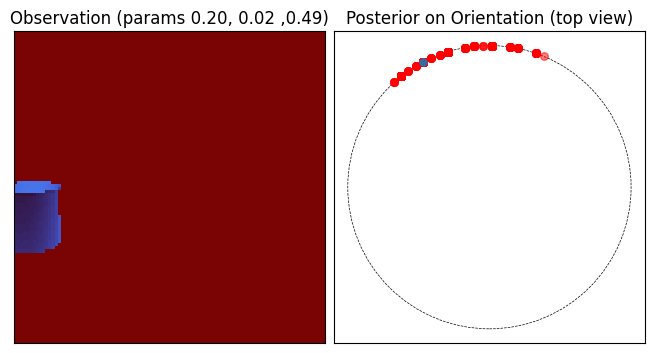

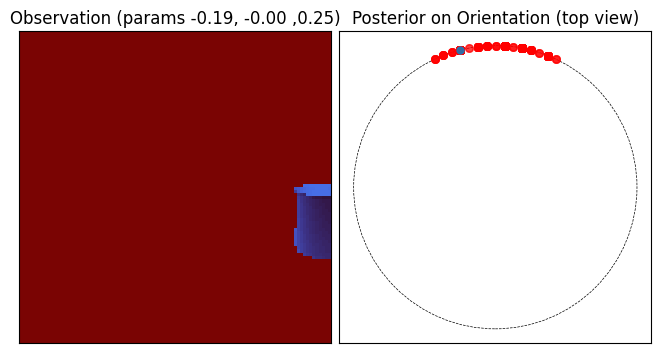

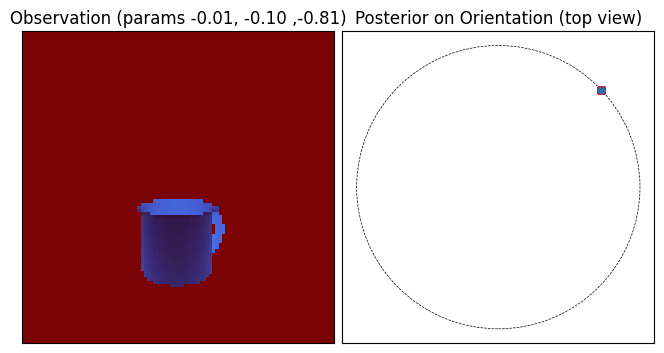

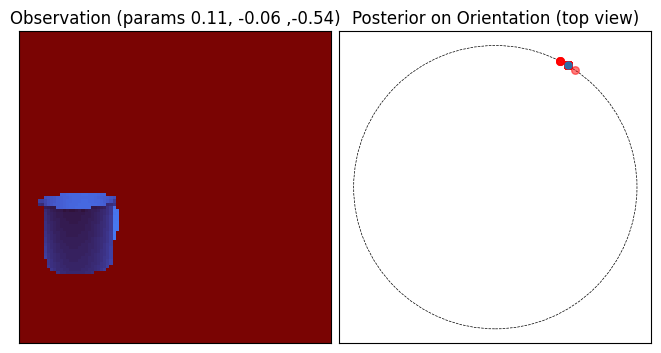

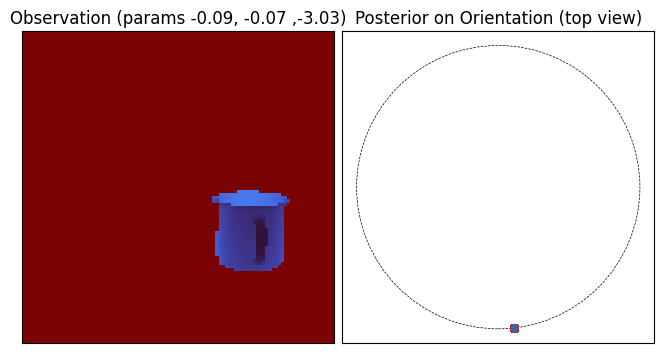

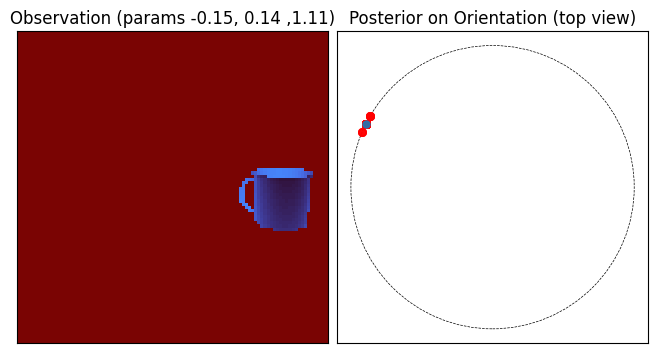

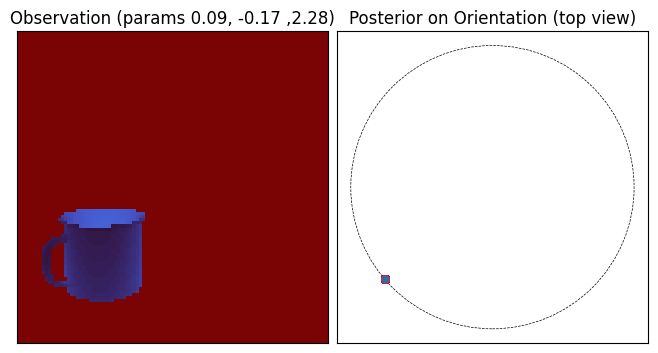

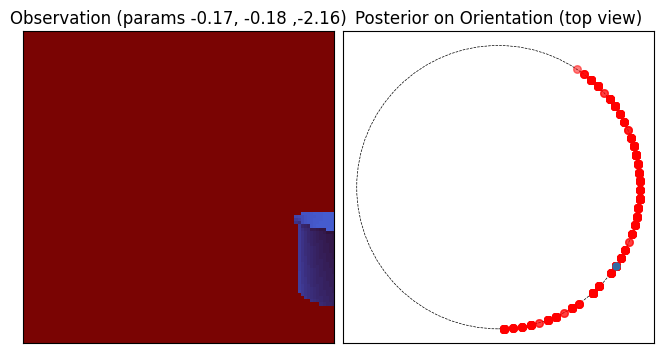

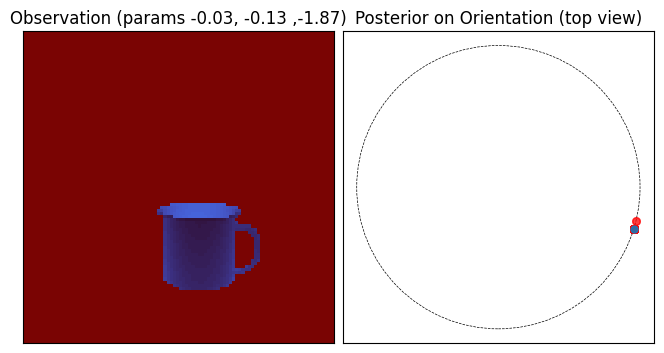

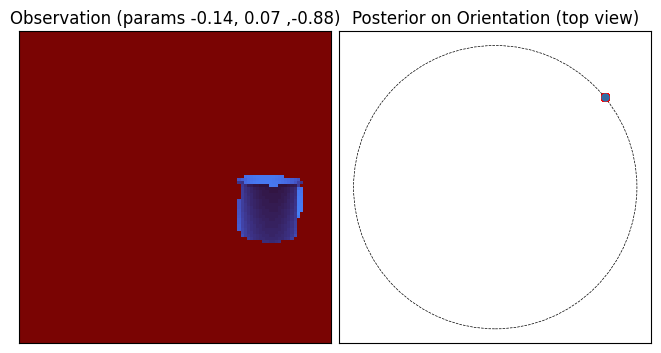

In [89]:
# key = jax.random.PRNGKey(100)
pathlib.Path('mug_results').mkdir(parents=True, exist_ok=True) 
for experiment_iteration in tqdm(range(10)):
    key = jax.random.split(key, 1)[0]
    weight, trace = importance_jit(key, genjax.choice_map({
        "parent_0": -1,
        "parent_1": 0,
        "id_0": jnp.int32(21),
        "id_1": jnp.int32(13),
        "camera_pose": jnp.eye(4),
        "root_pose_0": table_pose,
        "face_parent_1": 3,
        "face_child_1": 2,
        "variance": 0.0001,
        "outlier_prob": 0.0000001,
        # "contact_params_1": jnp.array([0.0, 0.0, 0.0])
    }), (
        jnp.arange(2),
        jnp.arange(22),
        jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
        jnp.array([jnp.array([-0.2, -0.2, -jnp.pi]), jnp.array([0.2, 0.2, jnp.pi])]),
        b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
    )
    b.show_trimesh("1", b.RENDERER.meshes[13])
    b.set_pose("1", b.get_poses(trace)[1])
    print(trace["contact_params_1"])
    contact_param_grid = trace["contact_params_1"] + contact_param_deltas
    weights =  jnp.concatenate([
        enumerators[3](trace, key, cp)
        for cp in jnp.array_split(contact_param_grid, 60)
    ],axis=0)
    
    normalized_weights = b.utils.normalize_log_scores(weights)
    sampled_indices = jax.random.choice(key2,jnp.arange(normalized_weights.shape[0]), shape=(1000,), p=normalized_weights)
    sampled_contact_params = contact_param_grid[sampled_indices]

    fig = make_orientation_posterior_viz(trace["image"], trace["contact_params_1"], sampled_contact_params)
    fig.savefig(f'mug_results/{experiment_iteration:05d}.png')


In [23]:
# import imageio
# images = [imageio.imread(f'mug_results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(50))]
# imageio.mimsave("mug_results.gif", images, 'GIF', duration=1200)

In [ ]:
trace.get_score()

0.0
52615.22
52633.21
[1.534943e-08 1.000000e+00]


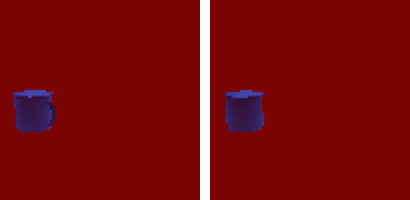

In [15]:
idx = sampled_contact_params[:,2].argmin()
new_trace = enumerators[0](trace,key, sampled_contact_params[idx])
normalized_weights = b.utils.normalize_log_scores(weights)
print(normalized_weights[idx])
print(trace.get_score())
print(new_trace.get_score())
print(b.utils.normalize_log_scores(jnp.array([trace.get_score(), new_trace.get_score()])))
b.viz_trace_rendered_observed(new_trace)

False
52666.46 52684.453
number that are better  295
total that are better  35.41522
number that are worse  396
total that are worse  -17.419804
0.74521494
56 24
[-0.11529334  0.02660616  0.8868719 ]
[-0.11529334  0.02660616  0.8868719 ]
[-0.1164979   0.02688413  0.8961377 ]
5.447435
6.19265


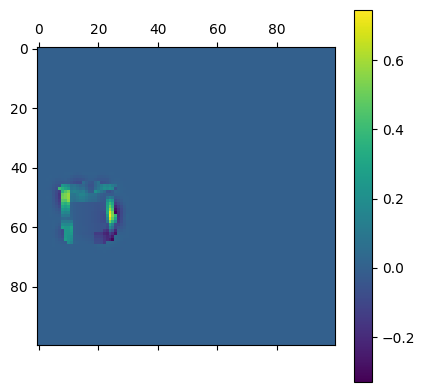

In [18]:
scores1 = b.get_pixelwise_scores(trace, 3)
scores2 = b.get_pixelwise_scores(new_trace, 3)
print(scores1.sum() > scores2.sum())
print(scores1.sum(), scores2.sum())
diff = (scores2 - scores1)
plt.matshow(diff)


print("number that are better ", (diff > 0).sum())
print("total that are better ", diff[(diff > 0)].sum())
print("number that are worse ", (diff < 0).sum())
print("total that are worse ", diff[(diff < 0)].sum())

i,j = jnp.unravel_index((scores2 - scores1).argmax(), scores2.shape)
print((scores2 - scores1)[i,j])
print(i,j)
print(trace["image"][i,j])
print(b.get_rendered_image(trace)[i,j])
print(b.get_rendered_image(new_trace)[i,j])
print(scores1[i,j])
print(scores2[i,j])
plt.colorbar()

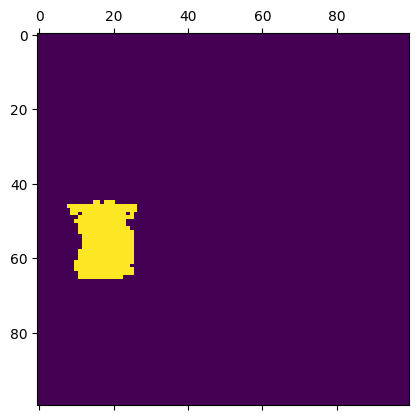

In [75]:
plt.matshow(diff > 0 )

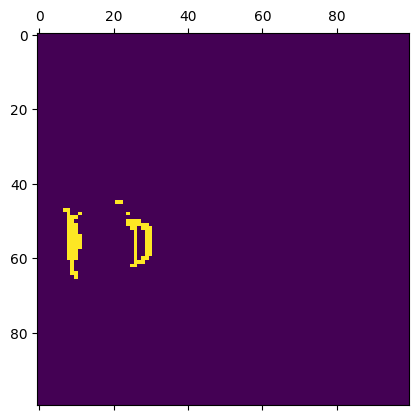

In [76]:
plt.matshow(diff < 0 )

In [44]:
filter_scores = convolutional_filter(
    jnp.array([i,j]),
    trace["image"],
    b.get_rendered_image(trace),
    trace["variance"],
    trace["outlier_prob"],
    b.get_outlier_volume(trace),
    b.get_focal_length(trace),
    3
)

NameError: name 'width_observed' is not defined

In [2]:
print(filter_scores[3,3])
print(filter_scores_new[0,6])

print(trace["image"][i,j])

print(filter[3,3])
print(filter_new[0,6])

NameError: name 'filter_scores' is not defined

In [105]:

def score(p, latent, focal_length, variance):
    print("p: ", p)
    half_widths = latent[2] / focal_length /2.0
    width_observed = (p[2] / focal_length)
    delta = jnp.array([half_widths, half_widths, 0.0])
    bottom_lefts = latent - delta
    top_rights =  latent + delta
    
    x_term = jax.lax.erf(
        (bottom_lefts[0] - p[0]) / (jnp.sqrt(2) * jnp.sqrt(variance))
    ) - jax.lax.erf(
        (top_rights[0] - p[0]) / (jnp.sqrt(2) * jnp.sqrt(variance))
    )

    y_term = jax.lax.erf(
        (bottom_lefts[1] - p[1]) / (jnp.sqrt(2) * jnp.sqrt(variance))
    ) - jax.lax.erf(
        (top_rights[1] - p[1]) / (jnp.sqrt(2) * jnp.sqrt(variance))
    )
    return x_term * y_term

p = jnp.array([-0.26  ,0.0006 , 2.  ])
f1 = p
f2 = jnp.array([-0.22999999  ,0.03      ,  2.        ])
print(score(p, f1, 200.0, 0.01))
print(score(p, f2, 200.0, 0.01))
    

p:  [-2.6e-01  6.0e-04  2.0e+00]
0.006360888
p:  [-2.6e-01  6.0e-04  2.0e+00]
0.005824215


In [88]:
jnp.log()

Array(nan, dtype=float32, weak_type=True)

In [68]:
trace["image"][i,j], filter_new[0,6]

(Array([-0.26,  0.06,  2.  ], dtype=float32),
 Array([-0.22999999,  0.03      ,  2.        ], dtype=float32))

In [66]:
filter[3,3]

Array([-0.26,  0.06,  2.  ], dtype=float32)

In [54]:
erf = jax.lax.erf
def single_patch_likelihood(p: jnp.ndarray,
                            latent,
                            focal_length,
                            sigma: float):
    half_widths = latent[2] / focal_length /2.0
    width_observed = (p[2] / focal_length)
    delta = jnp.array([half_widths, half_widths, 0.0])
    bottom_left = p - delta
    top_right = p + delta
    x, y, z = bottom_left
    X, Y, _ = top_right
    C = (2*jnp.pi)**(-3/2)  * sigma**(-3)
    z_term = jnp.exp(- (p[2] - z)**2/sigma**2)
    x_term = jnp.sqrt(jnp.pi) * sigma / 2 * (erf((p[0] - 2*x) / sigma) + erf((- p[0] + x + X) / sigma))
    y_term = jnp.sqrt(jnp.pi) * sigma / 2 * (erf((p[1] - 2*y) / sigma) + erf((- p[1] + y + Y) / sigma))
    print(x_term, y_term, z_term)
    return C * x_term * y_term * z_term

In [64]:
jax.lax.erf

<function jax._src.lax.special.erf(x: Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, bool, int, float, complex]) -> jax.Array>

In [62]:
single_patch_likelihood(
    trace["image"][i,j],
    filter[3,3],
    b.get_focal_length(trace), 0.1
)

9.001081e-06 0.0073872516 1.0


Array(4.221898e-06, dtype=float32)

In [48]:
trace["image"][i,j], filter[3,3]

(Array([-0.26,  0.06,  2.  ], dtype=float32),
 Array([-0.26,  0.06,  2.  ], dtype=float32))

In [33]:
trace["image"][i,j]

Array([-0.26,  0.06,  2.  ], dtype=float32)

In [45]:
print(filter[3,3])
print(filter_new[3,3])

-5.575178
-151.78525


In [ ]:
latent

In [44]:
print(get_latent_filter(    jnp.array([i,j]),
    trace["image"],
    b.get_rendered_image(trace),3)[3,3])

print(get_latent_filter(    jnp.array([i,j]),
    new_trace["image"],
    b.get_rendered_image(new_trace),3)[3,3])

[-0.26  0.06  2.  ]
[-0.10228802  0.02360493  0.7868309 ]


Array(-4.5982857, dtype=float32)

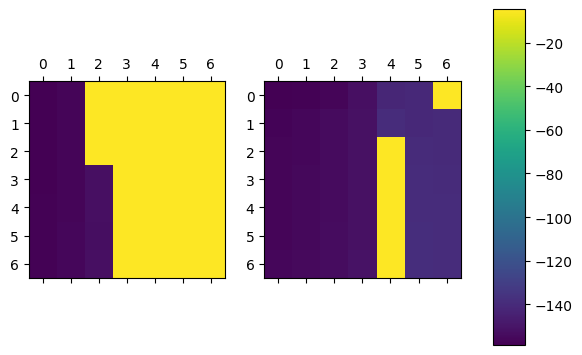

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2)
im = axes[0].matshow(filter)
im = axes[1].matshow(filter_new)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

In [10]:
import imageio
images = [imageio.imread(f'results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(50))]
imageio.mimsave("mug_results.gif", images, 'GIF', duration=1200)

  0%|                                                                 | 0/50 [00:00<?, ?it/s]/var/tmp/ipykernel_568436/2655208105.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(f'results/{experiment_iteration:05d}.png') for experiment_iteration in tqdm(range(50))]


FileNotFoundError: No such file: '/home/nishadgothoskar/bayes3d/scripts/experiments/icra/mug/results/00000.png'